# Topic Analysis

With trained topic models and a Joint-KNN representation of the data, we can analyze the topics to understand the regulatory dynamics present within a sample. Expression topics may be analyzed with functional enrichments of the top genes activated in a given topic/module. Accessibility topics correspond to a set of coordinated *cis*-regulatory elements, and may be analyzed to find emergent transcription factor regulators of particular cell states.

This tutorial will cover predicting factor binding and analyzing topic modules in both modes. First, we import packages:

In [36]:
import mira
import anndata
import scanpy as sc
import pandas as pd
import logging
import charset_normalizer
import numpy as np
charset_normalizer.logging.getLogger().setLevel(logging.WARN)
mira.logging.getLogger().setLevel(logging.INFO)
mira.utils.pretty_sderr()

And load the SHARE-seq data and topic models:

In [2]:
rna_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/rna_data.h5ad')
atac_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/atac_data_raw_counts_only.h5ad')

In [4]:
rna_model = mira.topics.ExpressionTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [5]:
atac_data = atac_data[rna_data.obs_names]
atac_data.obsm['X_umap'] = rna_data.obsm['X_umap']
atac_model.predict(atac_data)

Predicting latent vars:   0%|          | 0/56 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


We pick up from the previous tutorial, making the **joint representation**, in which we constructed a UMAP view of the data. We can visualize the flow of topics to illustrate how they captured aspects of the differentiation process. For instance, we can plot expression topics 6 and 13, which mark matrix cells of the hair follicle and granular cells of the epidermis, respectively:

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'highly_variable' as categorical


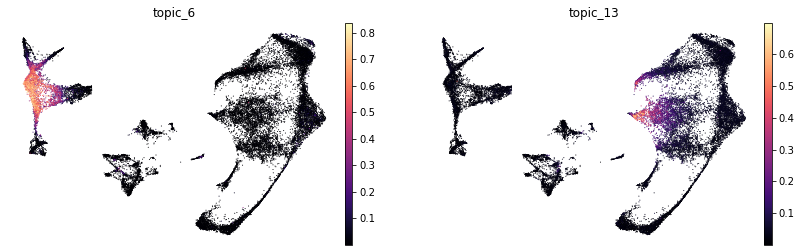

In [6]:
sc.pl.umap(rna_data, color  = ['topic_6', 'topic_13'], frameon=False, ncols=2,
          color_map = 'magma')

## Expression Topic Analysis

We can plot expression patterns of genes that are activated by these topics. To get the top genes associated with a topic:

In [7]:
rna_model.get_top_genes(6, top_n=3)

array(['GINS4', 'EDARADD', 'SHH'], dtype=object)

And plotting:

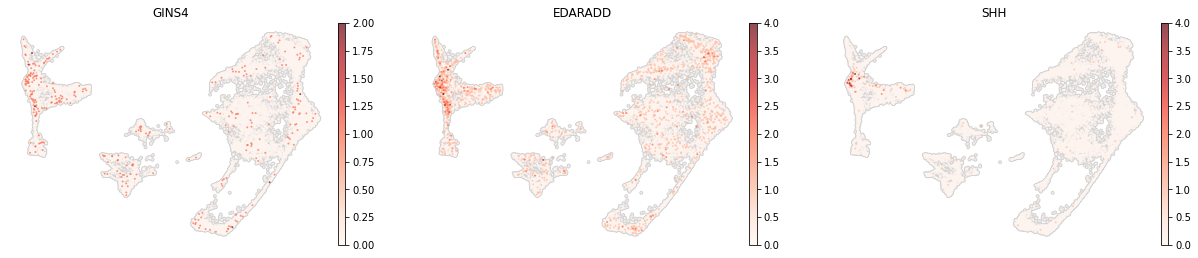

In [8]:
sc.pl.umap(rna_data, color = rna_model.get_top_genes(6, top_n=3), **mira.pref.raw_umap(ncols=3, size=15))

Above, the [mira.pref.raw_umap](../pref/mira.pref.raw_umap.html) function simply provides default values to the Scanpy plotting function to make easily readable plots for normalized expression values.

Let's see what functional enrichments represent these topics. MIRA uses [Enrichr](https://maayanlab.cloud/Enrichr/) to get functional enrichments for each topic by posting the `top_n` genes associated with a topic to their API. One can change the number of genes sent, or output genes sorted in order of activation by the topic for rank-based functional enrichments (like [GSEApy](https://gseapy.readthedocs.io/en/latest/introduction.html)).

To post a topic's top genes to Enrichr, use [post_topic](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.post_topic), or use [post_topics](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.post_topics) to post all topics' lists at once. 

In [9]:
rna_model.post_topic(6, top_n=500)
rna_model.post_topic(13, top_n=500)

Or retreive a sorted list of genes **(least activated to most activated)** via:

In [10]:
rna_model.rank_genes(6)

array(['WBSCR27', 'CCDC148', '4930533K18RIK', ..., 'GINS4', 'EDARADD',
       'SHH'], dtype=object)

To download the enrichment results, run [fetch_topic_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.fetch_topic_enrichments), or similarly run [fetch_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.fetch_enrichments) to download results for all topics. Here, one may provide list of onotologies to compare against. The ontologies available on Enrichr may be found [here](https://maayanlab.cloud/Enrichr/#libraries).

In [19]:
rna_model.fetch_topic_enrichments(6, ontologies= ['WikiPathways_2019_Mouse'])
rna_model.fetch_topic_enrichments(13, ontologies= ['WikiPathways_2019_Mouse','GO_Biological_Process_2018'])

To analyze enrichments, one can use:

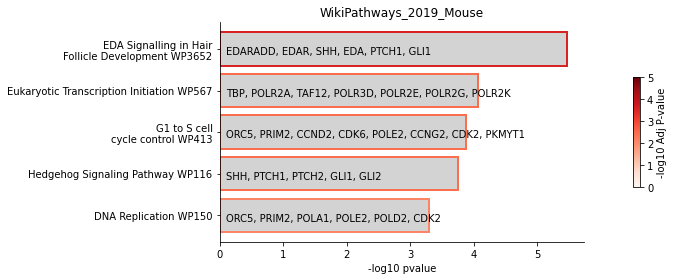

In [20]:
rna_model.plot_enrichments(6, show_top=5)

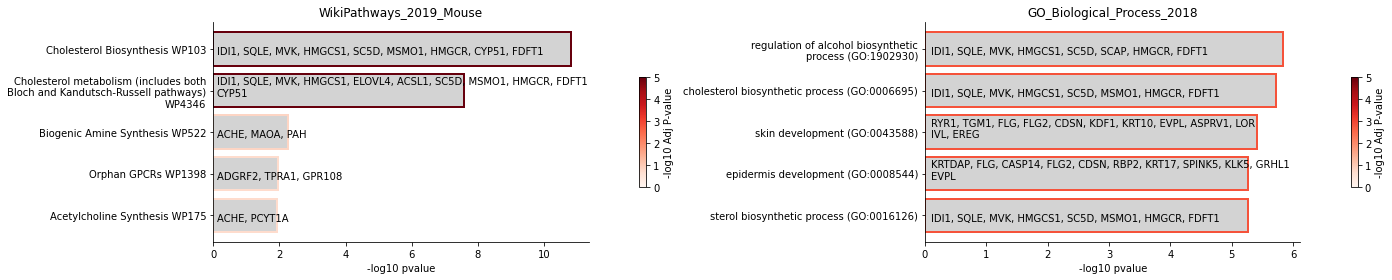

In [21]:
rna_model.plot_enrichments(13, show_top=5, plots_per_row=2)

For a full list of parameters, see [plot_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.plot_enrichments). One can also access the enrichment data using [get_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.get_enrichments):

In [22]:
pd.DataFrame(
    rna_model.get_enrichments(13)['WikiPathways_2019_Mouse']
).head(3)

,rank,term,pvalue,zscore,combined_score,genes,adj_pvalue
0,1,Cholesterol Biosynthesis WP103,1.555427e-11,59.553971,1482.100994,"[IDI1, SQLE, MVK, HMGCS1, SC5D, MSMO1, HMGCR, ...",1.291004e-09
1,2,Cholesterol metabolism (includes both Bloch an...,2.638391e-08,11.520934,201.046197,"[IDI1, SQLE, MVK, HMGCS1, ELOVL4, ACSL1, SC5D,...",1.094932e-06
2,3,Biogenic Amine Synthesis WP522,5.648025e-03,9.802817,50.743786,"[ACHE, MAOA, PAH]",1.562620e-01


## Accessibility Topic Analysis

Next, we will find transcription factor enrichments in accessibility topics. First, visualize the cell states represented by some topics:

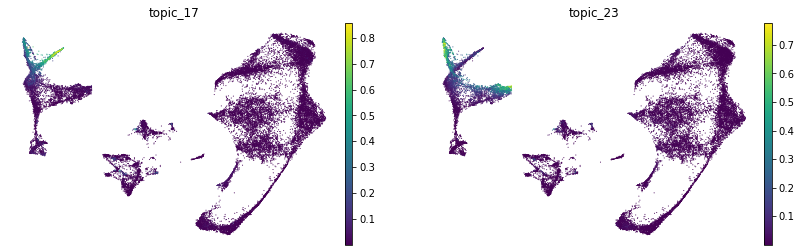

In [23]:
sc.pl.umap(atac_data, color = ['topic_17','topic_23'], frameon=False, palette='viridis')

ATAC topics 10 and 5 represent two terminal lineages of hair follicle differentiation. It would be interesting to compare and contrast transcription factors influential in these cell states. 

First, we must annotate transcription factor binding sites in our peaks using motif scanning. For this, we need the fasta sequence of the organism's genome. We must also ensure that we indicate the correct columns in the ATAC AnnData object corresponding to the chromosome, start, and end locations of each peak.

In [24]:
atac_data.var.head(3)

,chr,start,end,endogenous
peak_id,,,,
2,chr9,123461850,123462150,True
3,chr1,56782095,56782395,False
4,chr9,56223668,56223968,True


Use the function [mira.tl.get_motif_hits_in_peaks](../Tools/mira.tl.get_motif_hits_in_peaks.html):

In [27]:
mira.tl.get_motif_hits_in_peaks(atac_data, 
                    genome_fasta='/Users/alynch/genomes/mm10/mm10.fa', 
                    chrom = 'chr', start = 'start', end = 'end') # indicate chrom, start, end of peaks

INFO:mira.tools.motif_scan:Getting peak sequences ...
334124it [01:11, 4690.25it/s]
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits .

The function above loads the motif hits into a (n_factors x n_peaks) sparse matrix in `.varm['motif_hits']`, where values are the MOODS3 "Match Score" given a motif PWM and the peak's sequence. All matches that do not meet the p-value threshold were filtered. 

The metadata on the motifs scanned are stored in `.uns['motifs']`, and can be accessed by `mira.utils.fetch_factor_meta`.

In [28]:
mira.utils.fetch_factor_meta(atac_data).head(3)

,id,name,parsed_name
0,MA0397.1,STP4,STP4
1,MA1153.1,SMAD4,SMAD4
2,MA0083.3,SRF,SRF


An AnnData object of motif hits can be accessed with `mira.utils.fetch_motif_hits`:

In [30]:
mira.utils.fetch_factor_hits(atac_data)

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1646 × 334124
    obs: 'id', 'name', 'parsed_name'
    var: 'chr', 'start', 'end', 'endogenous'

Motif calling often includes many factors that may be irrelevant to the current system. Usually, it is convenient to filter out TFs for which we do not have expression data. Below, we use `mira.utils.subset_factors` to filter out TFs that do not have any associated data in the `rna_data` object (in addition to AP1 since these motifs clog up the plots we're about to make).

**Important: Do not filter out TFs on the basis of mean expression or dispersion, as many TFs can influence cell state without being variably expressed.**

This function marks certain factors as not to be used, but does not remove them from the AnnData. This way, you can use a different filter or include different factors in your analysis without re-calling motifs.

In [31]:
mira.utils.subset_factors(atac_data, 
                          use_factors=[factor for factor in rna_data.var_names 
                                       if not ('FOS' in factor or 'JUN' in factor)])

INFO:mira.adata_interface.utils:Found 528 factors in expression data.


With motifs called and a trained topic model, we find which motifs are enriched in each topic:

In [32]:
atac_model.get_enriched_TFs(atac_data, topic_num=17, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num=23, top_quantile=0.1)

Finding enrichments:   0%|          | 0/528 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/528 [00:00<?, ?it/s]

The parameter of the function above, `top_quantile`, controls what quantile of peaks are taken to represent the topic. Values between 0.1 and 0.2, so the top 10% to 20% peaks, work best. If a certain topic is enriching for non-specific factors, decrease the quantile used to take more topic-specific peaks.

One can retrieve enrichment results using [get_enrichments](../topicmodeling/mira.topics.AccessibilityTopicModel.html#mira.topics.AccessibilityTopicModel.get_enrichments). Note, this list is not sorted:

In [33]:
pd.DataFrame(atac_model.get_enrichments(23)).head(3)

,id,name,parsed_name,pval,test_statistic
0,MA1153.1,SMAD4,SMAD4,4.287406e-01,1.004564
1,MA0083.3,SRF,SRF,9.034861e-01,0.956426
2,MA0907.1,HOXC13,HOXC13,6.261397e-188,1.942430


Comparing and contrasting TF enrichments between topics elucidates common and topic-specific regulators. For this, one can use [plot_compare_topic_enrichments](../topicmodeling/mira.topics.AccessibilityTopicModel.html#mira.topics.AccessibilityTopicModel.plot_compare_topic_enrichments), which plots the -log10 p-value of TF enrichment for one topic vs. another. Below, we see that topic 23 is enriched for homeobox factors, while both topics share enrichment for HOX and WNT factors.

<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

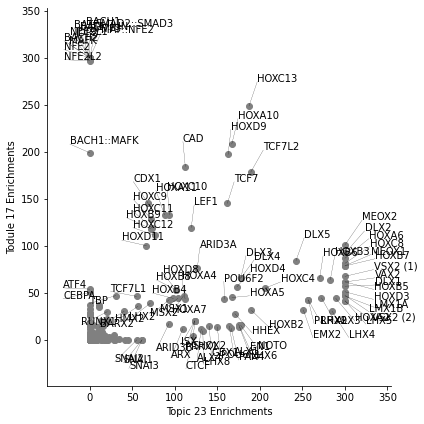

In [34]:
atac_model.plot_compare_topic_enrichments(23, 17,
            fontsize=10, label_closeness=3, figsize=(6,6),
        )

One can color the TFs on the plot to help narrow down import TFs. We could color by expression levels in our cell types of interest:

<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

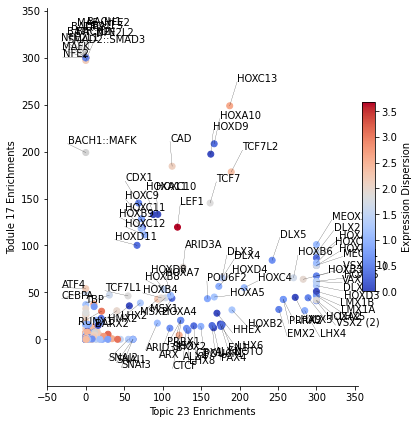

In [37]:
total_expression_in_cells = np.log10(
    np.squeeze(np.array(rna_data[rna_data.obs.true_cell.isin(['Cortex','Medulla'])].X.sum(0))) + 1
)

atac_model.plot_compare_topic_enrichments(23, 17,
            hue = {factor : disp  for factor, disp in zip(rna_data.var_names, total_expression_in_cells)},
            palette = 'coolwarm', legend_label='Expression Dispersion',
            fontsize=10, label_closeness=3, figsize=(6,6)
        )

To color TFs, pass a dictionary to the `hue` parameter where keys are gene names and values are the associated plotting data. You can pass a dictionary containing any and all genes. When the plotting function needs a color for a TF, it will look up that TF in the dictionary. If a TF is not found, its color will default to the `na_color` parameter.

Guided by domain knowledge and the coloring above, we can highlight certain factors to de-clutter the plot and prepare it for presenting. Below, I pass a list of influential regulators to the `label_factors` parameter.

<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

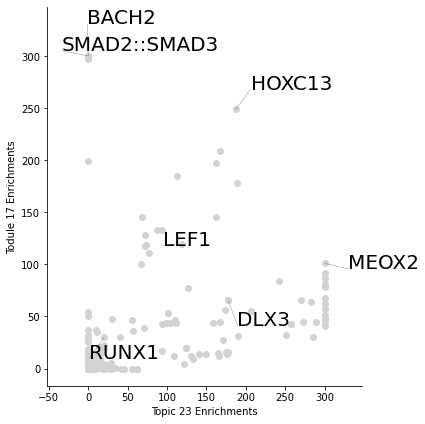

In [38]:
label = ['LEF1','HOXC13','MEOX2','DLX3','BACH2','RUNX1', 'SMAD2::SMAD3']
atac_model.plot_compare_topic_enrichments(23, 17,
            label_factors = label, 
            color = 'lightgrey',
            fontsize=20, label_closeness=5, 
            figsize=(6,6)
        )

# Motif scoring

It can be useful to see in which cell states a certain motif is more accessible/influential than others. One can calculate motif scores, in MIRA's case, the log-probability of sampling a motif-associated accessible region from the posterior predictive distribution over regions from the topic model:

In [39]:
motif_scores = atac_model.get_motif_scores(atac_data)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...


Imputing features:   0%|          | 0/56 [00:00<?, ?it/s]

Reformat the adata to make it convenient for plotting:

In [40]:
motif_scores.var = motif_scores.var.set_index('parsed_name')
motif_scores.var_names_make_unique()
motif_scores.obsm['X_umap'] = atac_data.obsm['X_umap']

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'name' as categorical


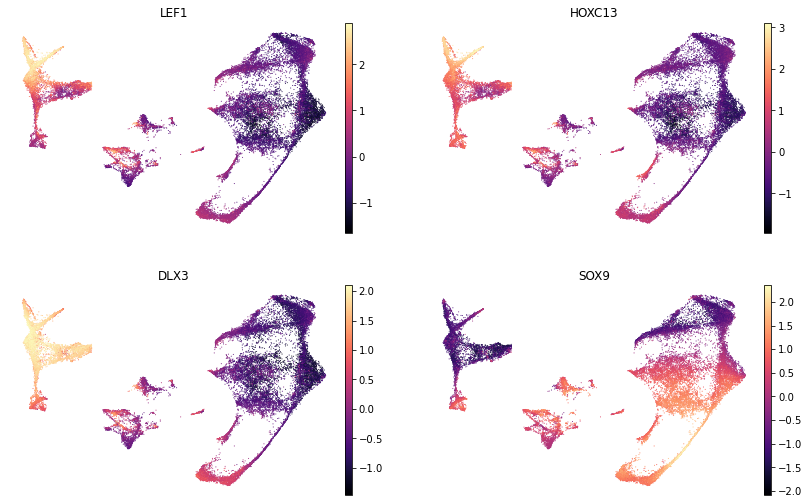

In [41]:
sc.pl.umap(motif_scores, color = ['LEF1', 'HOXC13','DLX3','SOX9'], 
           frameon=False, color_map='magma', ncols=2)

Topic analysis begins to answer questions of which regulators and functional axes determine cell state. In the next tutorial, we will show how topics may be combined with pseudotime trajectory inference to study state dynamics.